# TP2: Seafloor classification par CNN 

## 1 - Introduction

Disposant d'un ensemble d'images dont on veut prédire la classe, deux possibilités s'offrent pour apprendre un modèle profond de classement.

- La première possibilité se nomme "Transfer Learning" associé au "fine tuning" dont les principes sont d'utiliser un réseau de neurones profond entrainé dans un autre contexte et de l'adapter à nos données: 
    
- La seconde possibilité est de créer et d'entrainer un modèle profond ex-nihilo (from scratch, en partant de zéro).


L'objectif de ce TP est d'appliquer ces deux possibilités au problème de classification de patchs d'images sonar en types de fond marin que vous avez déjà traités dans les TPs précédent. Vous reprendrez les fonctions d'import des patchs que vous avez déjà mises au point lors des tps précédents.

Il pourra être néanmoins utile d'utiliser les lignes de code suivantes pour que les données soient dans la forme attendue par tensoflow/keras et éventuellement changer la taille des images:
```python
from keras.preprocessing.image import img_to_array, load_img
target_size = 192;
feature_values = np.array([img_to_array(load_img(img,  # color_mode = "grayscale",
             target_size=(target_size, target_size))) for img in dataset_df['image_path'].values.tolist()
]).astype('float32')
```
A noter que la taille des patchs est automatiquement réduite à 192x192 pixels, vous pouvez réduire cette taille en fonction des performances de votre machine. Attention, une taille trop basse peut impliquer une erreur si vous réutilisez par la suite un modèle déjà entrainé (par exemple VGG16).

La création d'ensemble d'apprentissage, de validation et de test se fera en divisant la base en trois parts. Il faudrait pour ce petit jeu de données réaliser une procédure de cross-validation. Compte tenu du temps pour réaliser cette procédure, elle sera ici laissée de coté. 

## 1 - Tutorials CNN et transfer learning par fine tuning

Dans le startercode, vous trouverez un jupyter notebooks qui vous servira de base pour réaliser la suite. Dans un premier temps, le notebook détaille le fonctionnement et la mise en oeuvre des CNNs (en particulier les différentes couches d'un CNN avec des exemples); pour ensuite détailler la procédure liée au fine tuning avec data augmentation à partir de données de type TensorFlow Dataset. 

Veillez à bien suivre les différentes étapes et à bien comprendre les différentes commandes employées. Si vous voulez d'autres exemples, vous trouverez d'autres ressources supplémentaires.


## 2 - Transfer learning par fine tuning sur le dataset seafloor

- Vous commencerez par le fine tuning en vous inspirant du tuto fourni ci-dessus pour faire du transfer learning du modèle xception (dont les paramètres ont été appris sur la base d'images "imageNet") pour l'appliquer aux patchs d'images sonar. Vous procéderez ainsi:
  - les modèles sont téléchargeables ici si vous avez des problèmes pour télécharger: https://drive.google.com/open?id=1qFwqoNU1fsvl8fu-7eRCmjoPNZZNzPSJ
  - Résumer l'approche du transfer learning/fine tuning
  - Décriver l'architecture du modèle utilisé (xception ici)
  - Vous précisérez votre choix concernant les paramètres des fonctions appelées en particulier expliquer votre démarche concernant les phases de preprocessing des images, de data augmentation, de classification, etc.
  - remarque: comme les images sonar sont en niveaux de gris et que le modèle VGG prend en entrée des images couleurs, il s'agira de dupliquer ce canal sur les canaux R, G et B. 

  - Enfin, vous évaluerez les performances obtenues.
- (Bonus) comparez les résultats obtenus par l'architecture vgg16 (https://keras.io/applications/).

- (Bonus) Essayez et comparez les résultats obtenus par d'autres architectures (Resnet, Inception etc...https://keras.io/applications/).

## 3 - Proposition de votre propre achitecture  

- Vous proposerez ensuite une architecture de réseau profond convolutif et évaluerez ses performances. 
- Expliquez brièvement votre architecture et en particulier à quoi servent les couches (et leur enchainement) de votre architecture.
- Vous comparerez ensuite les performances obtenus (par rapport à ceux obtenus à la partie précédente) sur la matrice de confusion et les métriques de performance classiques.






# A rendre 
- pour le **12/01/21**
- la séance du 05/01/21 sera consacrée à finaliser
- **Commenter au maximum votre code (pourquoi vous utilisez tel ou tel bout de code) ou apporter des précisions dans votre CR.**
- au choix (**N'oublier pas les deux noms en cas de binômes**):
    - un fichier zip avec *.py et un cr au format pdf
    - un fichier .ipynb avec compte-rendu et code



# 4 - Aide pour démarrer

## 4.1 Chargement des données
Vous pourrez utiliser cette procédure pour charger les données: 
**A noter**
- target_size permet de définir un éventuel changement de taille des images qui pourra servir en fonction de la taille d'entrée du modèle que vous considérez.
- comme les images sonar sont en niveaux de gris et que le modèle VGG prend en entrée des images couleurs, load_img duplique ce canal sur les canaux R, G et B.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow.keras as keras
import pandas as pd
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from sklearn import preprocessing


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    DATASET_PATH = 'gdrive/My Drive/projet_IA/dataset/imgs/'
    LABEL_PATH = 'gdrive/My Drive/projet_IA/dataset/labels/labels.csv'
else:
    IN_COLAB = False
    DATASET_PATH = r'./dataset/imgs/'
    LABEL_PATH = r'./dataset/labels/labels.csv'



    
# 
target_size = 224
    
    
# Charger le fichier CSV

dataset_df = pd.read_csv(LABEL_PATH)


# We add another column to the labels dataset to identify image path
dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)

batch_imgs = np.array([img_to_array(
    load_img(img,  # color_mode = "grayscale",
             target_size=(target_size, target_size))
) for img
    in dataset_df['image_path'].values.tolist()
]).astype('float32')

print("shape = ", batch_imgs.shape)

#  Noms des labels dans l'ordre, respectivement aux indices
labelNames_unique = np.array(["Posidonia","Ripple 45°","Ripple vertical","Rock","Sand","Silt"])
labelDict={}
for i in range(len(labelNames_unique)):
    labelDict.update({i:labelNames_unique[i]})

    
# Récupération des labels
label_names = dataset_df['seafloor']


# nb de classes
label_nb = labelNames_unique.shape[0]

# indices
le = preprocessing.LabelEncoder()
le.fit(labelNames_unique)
labelIndices_unique = le.transform(labelNames_unique)
labelIndices  = le.transform(label_names)


# one-hot-encoding
labelOhe = pd.get_dummies(label_names.reset_index(drop=True)).values



shape =  (360, 224, 224, 3)


In [ ]:
# fonction d'aide pour afficher les courbes d'apprentissage
import matplotlib.pyplot as plt

def learningCurves(history,title):
    #Learning curve plotting
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epochs = list(range(1,NB_EPOCHS+1))
    ax1.plot(epochs, history['accuracy'], label='Train Accuracy')
    ax1.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(epochs)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend()

    ax2.plot(epochs, history['loss'], label='Train Loss')
    ax2.plot(epochs, history['val_loss'], label='Validation Loss')
    ax2.set_xticks(epochs)
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend()


## 4.2 - Définition, entrainer et évaleur le modèle VGG16 (par exemple) pour le fine tuning
Ensuite procéder comme le tuto:
- charger le modèle VGG16 sans le classifieur include_top=False
- Visualiser l'architecture du modèle: model.summary()
- Créer un modèle d'extraction d'information (features) allant de la couche d'entrée de VGG16 jusqu'à sa dernière couche de convolution nommée 'block3_pool'
- Rajouter des couches Dense pour définir un classifieur Fully connected (attention aux nombres de sorties de la dernière couche et à sa fonction d'activation)
- ne pas oublier l'étape de preprocessing essentiel à la bonne réussite de l'apprentissage. Il faut se renseigner sur les corrections à apporter et la taille des images d'entrée
- Compiler (compile), entrainer (fit) et évaluer (evaluate) le modèle


## Split des données

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest=train_test_split(batch_imgs, labelOhe, test_size=0.2)
print(xtrain.shape)

(288, 224, 224, 3)


## Transfer Learning: VGG16

### Preprocessing

In [ ]:
from keras.applications.vgg16 import preprocess_input
xtrain_vgg16 =preprocess_input(xtrain)
xtest_vgg16 =preprocess_input(xtest)

### Fine-tuning: Extraction des features

In [ ]:
# Loading of VGG16 and adding of the new full-connected 
old_model_vgg16 = keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))
x1=keras.layers.Flatten()(old_model_vgg16.output)
#x2=keras.layers.Dense(3000, activation='relu')(x1)
x3=keras.layers.Dense(4000, activation='relu')(x1)
output = keras.layers.Dense(labelNames_unique.size, activation="softmax")(x3)
new_model_vgg16 = keras.models.Model(inputs=old_model_vgg16.input, outputs=output)
#new_model_vgg16.summary()

for layer in old_model_vgg16.layers:
    layer.trainable = False

In [ ]:
# Training of the model
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
NB_EPOCHS=20
new_model_vgg16.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model_info = new_model_vgg16.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xval, yval), verbose=2)
history = new_model_vgg16.fit(xtrain_vgg16, ytrain, epochs=NB_EPOCHS, batch_size=10, validation_split= 0.2)

Epoch 1/20
23/23 [==============================] - 2s 88ms/step - loss: 5.5195 - accuracy: 0.4428 - val_loss: 2.9001 - val_accuracy: 0.8448
Epoch 2/20
23/23 [==============================] - 2s 76ms/step - loss: 2.8310 - accuracy: 0.7543 - val_loss: 0.7353 - val_accuracy: 0.8793
Epoch 3/20
23/23 [==============================] - 2s 76ms/step - loss: 0.3676 - accuracy: 0.9136 - val_loss: 2.9033 - val_accuracy: 0.8621
Epoch 4/20
23/23 [==============================] - 2s 76ms/step - loss: 1.0170 - accuracy: 0.8893 - val_loss: 0.2292 - val_accuracy: 0.9138
Epoch 5/20
23/23 [==============================] - 2s 76ms/step - loss: 0.1849 - accuracy: 0.8853 - val_loss: 0.2874 - val_accuracy: 0.9828
Epoch 6/20
23/23 [==============================] - 2s 77ms/step - loss: 0.0935 - accuracy: 0.9762 - val_loss: 2.0722 - val_accuracy: 0.9483
Epoch 7/20
23/23 [==============================] - 2s 77ms/step - loss: 0.0366 - accuracy: 0.9924 - val_loss: 0.7995 - val_accuracy: 0.9483
Epoch 8/20
23

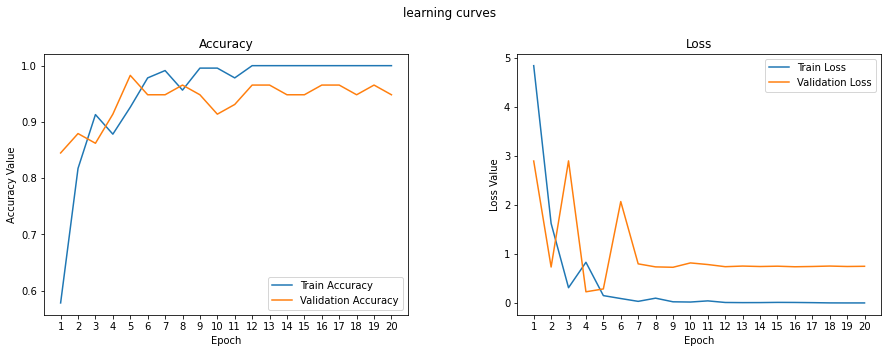

In [ ]:
# Learning curve
learningCurves(history.history, 'learning curves')

In [ ]:
# Evaluation
score = new_model_vgg16.evaluate(xtest_vgg16, ytest)

3/3 [==============================] - 0s 91ms/step - loss: 0.1029 - accuracy: 0.9583


### Fine-Tuning: Total

In [ ]:
# Loading of VGG16 and adding of the new full-connected 
old_model_vgg16 = keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))
x1=keras.layers.Flatten()(old_model_vgg16.output)
x2=keras.layers.Dense(4000, activation='relu')(x1)
output = keras.layers.Dense(labelNames_unique.size, activation="softmax")(x2)
new_model_vgg16 = keras.models.Model(inputs=old_model_vgg16.input, outputs=output)
new_model_vgg16.summary()

for layer in old_model_vgg16.layers:
    layer.trainable = True

In [ ]:
# Training of the modèle
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
NB_EPOCHS=20
new_model_vgg16.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model_info = new_model_vgg16.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xval, yval), verbose=2)
history = new_model_vgg16.fit(xtrain_vgg16, ytrain, epochs=NB_EPOCHS, batch_size=10, validation_split= 0.2)

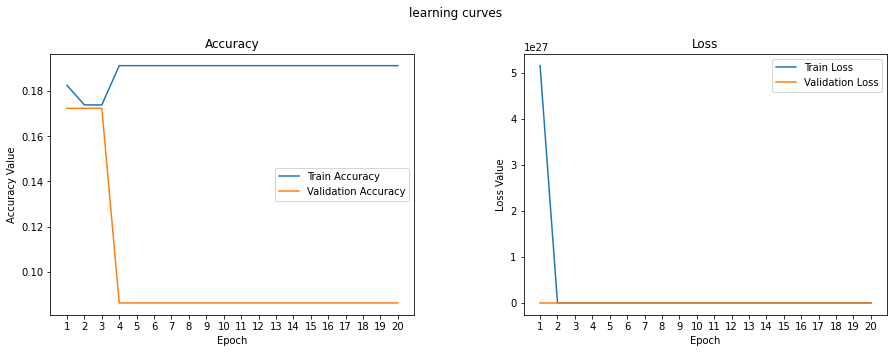

In [ ]:
# Learning curve
learningCurves(history.history, 'learning curves')

In [ ]:
# Evaluation du modèle
score = new_model_vgg16.evaluate(xtest_vgg16, ytest)

3/3 [==============================] - 0s 82ms/step - loss: 1.8041 - accuracy: 0.1528


## Transfer Learning: Resnet

### Preprocessing

In [ ]:
from keras.applications.resnet import preprocess_input
xtrain_resnet = preprocess_input(xtrain)
xtest_resnet = preprocess_input(xtest)

### Fine-tuning: Extraction des features

In [ ]:
# Loading of Resnet and adding of the new full-connected 
old_model_resnet = keras.applications.resnet.ResNet152(include_top=False, input_shape=(224,224,3))
x1=keras.layers.Flatten()(old_model_resnet.output)
x2=keras.layers.Dense(5000, activation='relu')(x1)
output = keras.layers.Dense(labelNames_unique.size, activation="softmax")(x2)
new_model_resnet = keras.models.Model(inputs=old_model_resnet.input, outputs=output)
#new_model_resnet.summary()

for layer in old_model_resnet.layers:
    layer.trainable = False

In [ ]:
# Training of the model
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
NB_EPOCHS=20
new_model_resnet.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model_info = new_model_vgg16.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xval, yval), verbose=2)
history = new_model_resnet.fit(xtrain_resnet, ytrain, epochs=NB_EPOCHS, batch_size=10, validation_split= 0.2)

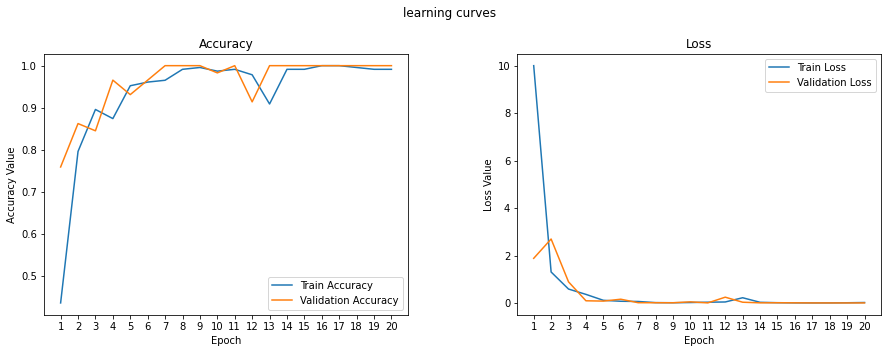

In [ ]:
# Learning curve
learningCurves(history.history, 'learning curves')

In [ ]:
# Evaluation
score = new_model_resnet.evaluate(xtest_resnet, ytest)

3/3 [==============================] - 1s 155ms/step - loss: 0.1311 - accuracy: 0.9444


### Fine-Tuning: Total

In [ ]:
# Loading of Resnet and adding of the new full-connected 
old_model_resnet = keras.applications.resnet.ResNet152(include_top=False, input_shape=(224,224,3))
x1=keras.layers.Flatten()(old_model_resnet.output)
x2=keras.layers.Dense(4000, activation='relu')(x1)
output = keras.layers.Dense(labelNames_unique.size, activation="softmax")(x2)
new_model_resnet = keras.models.Model(inputs=old_model_resnet.input, outputs=output)
#new_model_resnet.summary()

for layer in old_model_resnet.layers:
    layer.trainable = True

ResourceExhaustedError: ignored

In [ ]:
# Training of the model
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
NB_EPOCHS=20
new_model_resnet.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model_info = new_model_vgg16.fit(xtrain, ytrain, epochs=10, batch_size=32, validation_data=(xval, yval), verbose=2)
history = new_model_resnet.fit(xtrain_resnet, ytrain, epochs=NB_EPOCHS, batch_size=10, validation_split= 0.2)

In [ ]:
# Learning curve
learningCurves(history.history, 'learning curves')

In [ ]:
# Evaluation du modèle
score = new_model_vgg16.evaluate(xtest, ytest)

## Transfert Learning: inception

## 4.3 - Fonctions d'aide


In [ ]:
xmean = xtrain.mean(axis=0, keepdims=True)
xstd = xtrain.std(axis=0, keepdims=True)
xtrain = (xtrain - xmean) / xstd
xval = (xval - xmean) / xstd
xtest = (xtest - xmean) / xstd

In [ ]:

    
# fonction callback (à rajouter en option à model.fit) pour suivre l'évolution de la matrice de confusion au long de l'apprentissage
# credit: K. Bedin (ROB 2020) développé lors du cours
class ConfusionEvaluation(Callback):
    """
        Fonction callback pour la méthode 'fit_generator()' permettant d'afficher 
        la matrice de confusion à chaque fin d'Epoch.
        Cela permet de visualiser concraitement l'évolution de la classification au cours de l'apprentissage.
    """
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        preds_Inception = self.model.predict(self.X_val/255.)
        matrixInception = confusion_matrix(self.y_val,preds_Inception.argmax(axis=1))
        print("\nConfusion Matrix:")
        print(matrixInception)

#cbk_matconf = ConfusionEvaluation(validation_data=(featValues_val, labelInd_val))

    

# 5 -  Ressources supplémentaires en transfer learning par fine tuning**
 En dehors des supports de cours, vous pourrez aussi vous appuyer sur:
- Les concepts du transfer learning sont expliqués dans les liens ci-dessous:
  - https://www.youtube.com/watch?v=FQM13HkEfBk&index=20&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF
  - http://cs231n.github.io/transfer-learning/
  - https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html et https://flyyufelix.github.io/2016/10/08/fine-tuning-in-keras-part2.html
- Des exemples supplémentaires d'implémentation
  - https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/CIFAR10_CNN_Classifier.ipynb et https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/CIFAR10_VGG16_Transfer_Learning_Classifier.ipynb
  - https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/Dog_Breed_EDA.ipynb et https://github.com/dipanjanS/hands-on-transfer-learning-with-python/blob/master/notebooks/Ch06%20-%20Image%20Recognition%20and%20Classification/Dog_Breed_Transfer_Learning_Classifier.ipynb
- cours et des vidéos de Stanford University: https://www.youtube.com/watch?v=wEoyxE0GP2M&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=6, https://www.youtube.com/watch?v=wEoyxE0GP2M&list=PL3FW7Lu3i5JvHM8ljYj-zLfQRF3EO8sYv&index=7)
 